# FINE-TUNING DE RESNET50

# Imports, paramètres et configuartions

In [1]:
import os
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

from tqdm.auto import tqdm

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ===== CONFIG =====
SEED = 42
data_dir = "First_Trial"
IMAGE_SIZE = 224
BATCH_SIZE = 16

TRAIN_SPLIT = 0.8
VAL_SPLIT   = 0.1
TEST_SPLIT  = 0.1

NUM_EPOCHS = 30
LR = 3e-4
WEIGHT_DECAY = 1e-4

FINETUNE_MODE = "full"   # "head_only" ou "full"
FREEZE_FEATURES = False  # True => backbone gelé
UNFREEZE_LAST_N_LAYERS = 0  # 0..4 -> layer4 only=1, layer3+4=2, layer2+3+4=3, layer1..4=4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

Device: cuda


/home/vlin/.conda/envs/HDDLtorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset et robustesse

In [2]:
class FilteredImageFolder(ImageFolder):
    """Ignore les dossiers vides + skip images corrompues."""
    def find_classes(self, directory):
        classes = [
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
            and len(os.listdir(os.path.join(directory, d))) > 0
        ]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            img = Image.open(path).convert("RGB")
        except (OSError, ValueError):
            new_index = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(new_index)

        if self.transform is not None:
            img = self.transform(img)
        return img, target

# Data Preparation et Data Augmentation

In [3]:
weights = ResNet50_Weights.DEFAULT

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
    ),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Chargement du dataset : Train / Validation / Test - 80 / 20 / 20

In [4]:
full_dataset_train = FilteredImageFolder(root=data_dir, transform=train_transform)
full_dataset_eval  = FilteredImageFolder(root=data_dir, transform=eval_transform)

class_names = full_dataset_train.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(full_dataset_train))

N = len(full_dataset_train)
train_size = int(TRAIN_SPLIT * N)
val_size   = int(VAL_SPLIT * N)
test_size  = N - train_size - val_size  # pour tomber exactement juste

generator = torch.Generator().manual_seed(SEED)
train_idx, val_idx, test_idx = random_split(
    range(N),
    [train_size, val_size, test_size],
    generator=generator
)

train_dataset = torch.utils.data.Subset(full_dataset_train, train_idx.indices)
val_dataset   = torch.utils.data.Subset(full_dataset_eval,  val_idx.indices)
test_dataset  = torch.utils.data.Subset(full_dataset_eval,  test_idx.indices)

print(f"Split: train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

Classes: ['HERPES SIMPLEX (112)', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']
Total images: 1961
Split: train=1568, val=196, test=197


# Equilibrage des classes

In [5]:
train_targets = [full_dataset_train.samples[i][1] for i in train_idx.indices]
class_counts = Counter(train_targets)
print("Images par classe (train):", class_counts)

num_samples = len(train_targets)
class_weights = {c: num_samples / cnt for c, cnt in class_counts.items()}
sample_weights = [class_weights[t] for t in train_targets]

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

Images par classe (train): Counter({1: 396, 4: 333, 3: 225, 7: 200, 5: 179, 2: 89, 0: 86, 6: 60})


# Import de ResNet50 pré-entrainé sur ImageNet

In [ ]:
model = resnet50(weights=weights)

# Remplacer la couche finale pour les classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Backbone ResNet = tout sauf fc ; Head = fc
def freeze_backbone_resnet(model):
    for name, p in model.named_parameters():
        if not name.startswith("fc."):
            p.requires_grad = False

def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

def unfreeze_last_stages(model, n=1):
    """
    Dégèle les derniers stages: layer4 (1), layer3+layer4 (2),
    layer2+layer3+layer4 (3), layer1+layer2+layer3+layer4 (4)
    """
    freeze_backbone_resnet(model)  # geler tout backbone
    for p in model.fc.parameters():  # head toujours entraînable
        p.requires_grad = True

    stages = ["layer1", "layer2", "layer3", "layer4"]
    to_unfreeze = stages[-n:]
    for stage_name in to_unfreeze:
        for p in getattr(model, stage_name).parameters():
            p.requires_grad = True

# Appliquer stratégie
if FINETUNE_MODE == "head_only" or FREEZE_FEATURES:
    freeze_backbone_resnet(model)
    print("Mode: head_only (backbone gelé)")
else:
    unfreeze_all(model)
    print("Mode: full fine-tuning")

    if UNFREEZE_LAST_N_LAYERS > 0:
        unfreeze_last_stages(model, n=min(UNFREEZE_LAST_N_LAYERS, 4))
        print(f"Backbone: dégelé uniquement sur les {min(UNFREEZE_LAST_N_LAYERS,4)} derniers stages")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.AdamW(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/vlin/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s] 


Mode: full fine-tuning
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_s

/tmp/ipykernel_17102/3068470745.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# Entrainement du modèle et évaluation

In [7]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch, num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(loader, desc=f"Epoch [{epoch}/{num_epochs}] TRAIN", leave=False)

    for images, labels in progress_bar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        progress_bar.set_postfix({
            "loss": f"{running_loss / total:.4f}",
            "acc": f"{(correct / total) * 100:.2f}%",
            "lr": f"{optimizer.param_groups[0]['lr']:.1e}"
        })

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device, title="VAL"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(loader, desc=f"{title} EVAL", leave=False)

    for images, labels in progress_bar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        progress_bar.set_postfix({
            "loss": f"{running_loss / total:.4f}",
            "acc": f"{(correct / total) * 100:.2f}%"
        })

    return running_loss / total, correct / total

# Fine-tuning complet de ResNet50 avec early stop

In [8]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch, NUM_EPOCHS)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device, title="VAL")

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
        f"\nEpoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train acc {tr_acc*100:.2f}% "
        f"- Val acc {va_acc*100:.2f}% "
        f"- LR {optimizer.param_groups[0]['lr']:.2e}"
    )

    scheduler.step(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names,
            "img_size": IMAGE_SIZE,
        }, "resnet_best.pth")
        print(">> Nouveau meilleur modèle sauvegardé (resnet_best.pth)")

Epoch [1/30] TRAIN:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_17102/3660114449.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):



Epoch [1/30] - Train acc 62.37% - Val acc 59.18% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [2/30] - Train acc 78.64% - Val acc 62.76% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [3/30] - Train acc 84.38% - Val acc 67.35% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [4/30] - Train acc 86.22% - Val acc 72.45% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [5/30] - Train acc 89.54% - Val acc 71.43% - LR 3.00e-04



Epoch [6/30] - Train acc 91.65% - Val acc 77.55% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [7/30] - Train acc 90.62% - Val acc 75.51% - LR 3.00e-04



Epoch [8/30] - Train acc 92.22% - Val acc 73.98% - LR 3.00e-04



Epoch [9/30] - Train acc 94.58% - Val acc 78.06% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [10/30] - Train acc 93.75% - Val acc 74.49% - LR 3.00e-04



Epoch [11/30] - Train acc 94.96% - Val acc 69.90% - LR 3.00e-04



Epoch [12/30] - Train acc 95.41% - Val acc 73.47% - LR 3.00e-04



Epoch [13/30] - Train acc 93.49% - Val acc 72.96% - LR 3.00e-04



Epoch [14/30] - Train acc 97.32% - Val acc 78.06% - LR 1.50e-04



Epoch [15/30] - Train acc 97.58% - Val acc 78.06% - LR 1.50e-04



Epoch [16/30] - Train acc 98.09% - Val acc 78.57% - LR 1.50e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [17/30] - Train acc 98.79% - Val acc 79.08% - LR 1.50e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [18/30] - Train acc 98.60% - Val acc 81.12% - LR 1.50e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [19/30] - Train acc 98.21% - Val acc 81.12% - LR 1.50e-04



Epoch [20/30] - Train acc 98.09% - Val acc 78.06% - LR 1.50e-04



Epoch [21/30] - Train acc 98.53% - Val acc 79.59% - LR 1.50e-04



Epoch [22/30] - Train acc 98.79% - Val acc 81.63% - LR 1.50e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [23/30] - Train acc 98.60% - Val acc 76.53% - LR 1.50e-04



Epoch [24/30] - Train acc 98.85% - Val acc 80.10% - LR 1.50e-04



Epoch [25/30] - Train acc 98.98% - Val acc 82.14% - LR 1.50e-04
>> Nouveau meilleur modèle sauvegardé (resnet_best.pth)



Epoch [26/30] - Train acc 99.17% - Val acc 77.55% - LR 1.50e-04



Epoch [27/30] - Train acc 98.66% - Val acc 80.10% - LR 1.50e-04



Epoch [28/30] - Train acc 99.17% - Val acc 82.14% - LR 1.50e-04



Epoch [29/30] - Train acc 99.36% - Val acc 78.06% - LR 1.50e-04



Epoch [30/30] - Train acc 98.79% - Val acc 81.12% - LR 7.50e-05


# Courbes d'apprentissage

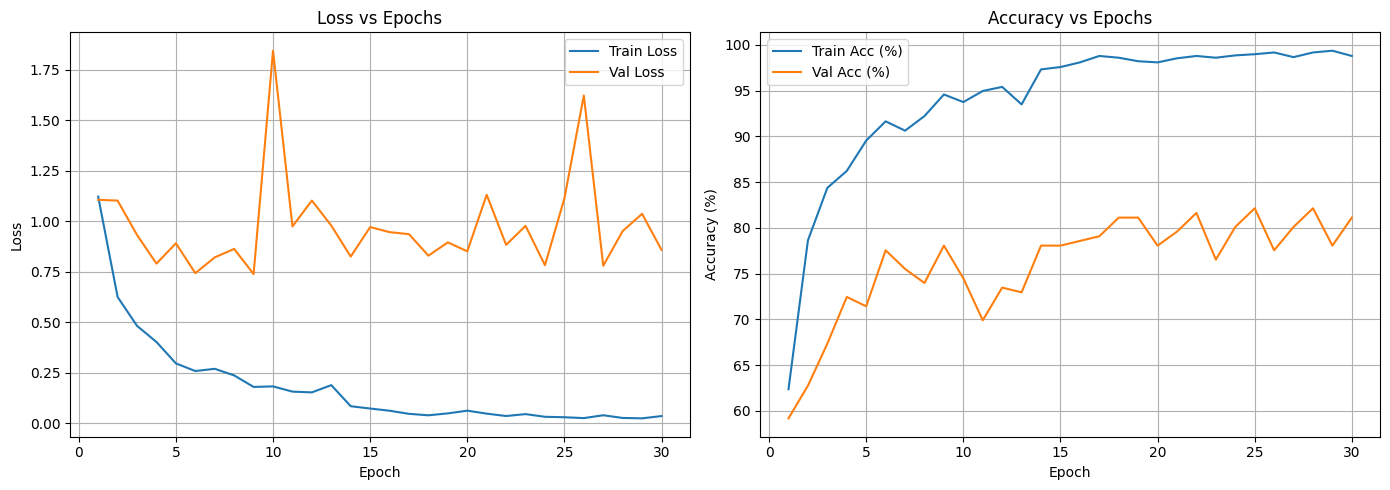

In [9]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in train_accs], label="Train Acc (%)")
plt.plot(epochs, [a * 100 for a in val_accs], label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Matrice de confusion

In [1]:
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def evaluate_and_report(model, loader, class_names, device, title="EVAL"):
    model.eval()
    all_labels, all_preds = [], []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = (all_labels == all_preds).mean()
    print(f"\nAccuracy globale ({title}): {acc*100:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    print(f"Matrice de confusion ({title}):\n", cm)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="Vraies classes",
        xlabel="Classes prédites",
        title=f"Matrice de confusion ({title})"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)
    print(f"\nRapport de classification ({title}):\n")
    print(report)

    per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
    print(f"Accuracy par classe ({title}):")
    for cls, a in zip(class_names, per_class_acc):
        print(f"  {cls}: {a*100:.2f}%")

    return acc, cm


ckpt = torch.load("resnet_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
model.to(device)
model.eval()

_ = evaluate_and_report(model, val_loader, class_names, device, title="VAL")
_ = evaluate_and_report(model, test_loader, class_names, device, title="TEST")

NameError: name 'torch' is not defined